In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

## GRADER PLEASE NOTE

* Some of the instructions are different from the original but still adhere to the rubric.
* The students get the average precipitation per day instead of every single precipitation value.

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [10]:
# Check column names and type
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Using this date, find the average precipitation per day
# for the preceding 12 months (365 days) of data sorted by ascending date.
months12_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
months12_ago

datetime.date(2016, 8, 23)

In [12]:
prcp_daily_avg = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    group_by(Measurement.date).\
                    filter(Measurement.date >= "2016-08-23")
# prcp_daily_avg

In [13]:
# Convert your results into a pandas DataFrame with date as index.
prcp_daily = pd.read_sql(prcp_daily_avg.statement, prcp_daily_avg.session.bind)
prcp_daily.head()

,date,avg_1
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


In [14]:
# Renaming column and setting date as the index
prcp_daily_avg_df = prcp_daily.rename(columns={"date": "Date", 
                                               "avg_1": "Precipitaion"})
prcp_daily_avg_df.set_index("Date")

,Precipitaion
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


In [15]:
# Resetting df index so that Date appears as the xticks
prcp_daily_avg_df1 = prcp_daily_avg_df.reset_index()

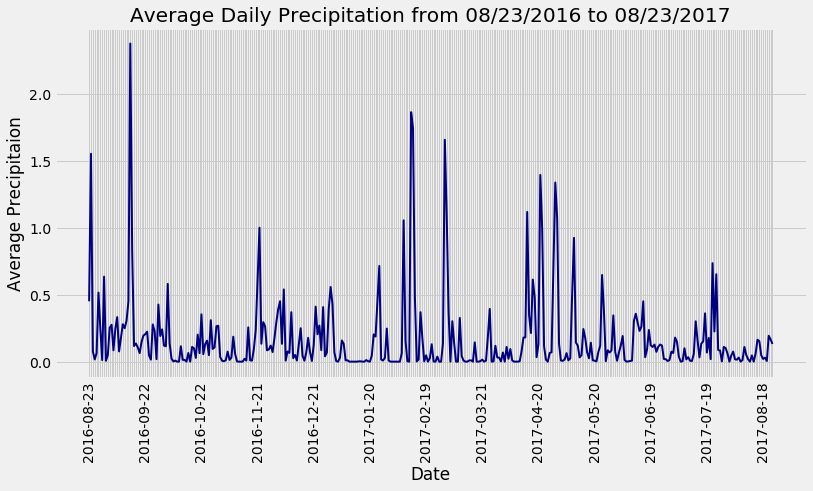

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data (Experimenting with Seaborn)
import seaborn as sns

plt.figure(figsize=(12,6))

plot = sns.lineplot(x=prcp_daily_avg_df1.Date, 
                    y=prcp_daily_avg_df.Precipitaion, 
                    color="navy", linewidth=2)

for i, j in enumerate(plot.get_xticklabels()):
    if i % 30 == 0:
        j.set_visible(True)
    else:
        j.set_visible(False)
        
plt.xticks(rotation=90)
plt.ylabel("Average Precipitaion")
plt.grid(True)
plt.title("Average Daily Precipitation from 08/23/2016 to 08/23/2017")
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_daily_avg_df.describe()

,Precipitaion
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [18]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Query total number of stations in dataset
num_of_stations = session.query(Station).count()
print(f"There are {num_of_stations} stations!")

There are 9 stations!


In [20]:
# Verifying number of stations using measurement data
stations = engine.execute("SELECT COUNT(DISTINCT station) FROM measurement").fetchall()
num_of_stations = stations[0][0]
num_of_stations

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
active_stations_id = active_stations[0][0]
staion_count_id = active_stations[0][1]
print(f"{active_stations_id} is the most active station with {staion_count_id} counts!")

USC00519281 is the most active station with 2772 counts!


In [23]:
# Using the station id from the previous query, calculate the lowest, 
# highest, and average temperature recorded for this station.
sum_stats = session.query(Measurement.station, func.min(Measurement.tobs),\
                          func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                            filter(Measurement.station == "USC00519281")

In [24]:
df = pd.read_sql(sum_stats.statement, sum_stats.session.bind)
sum_stats_df = df.rename(columns={"station": "Station", 
                                  "min_1": "Min_Temp", 
                                  "max_1": "Max_Temp", 
                                  "avg_1": "Avg_Temp"})
sum_stats_df

,Station,Min_Temp,Max_Temp,Avg_Temp
0,USC00519281,54.0,85.0,71.663781


In [25]:
# Query the last 12 months of temperature observation data for this station.
# Plot the results as a histogram with bins = 12.
temp = session.query(Measurement.tobs).\
                    filter(Measurement.date >= "2016-08-23").\
                    filter(Measurement.station == "USC00519281")

In [26]:
df_1 = pd.read_sql(temp.statement, temp.session.bind)
temp_df = df_1.rename(columns={"tobs": "Temperature"})
temp_df

,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


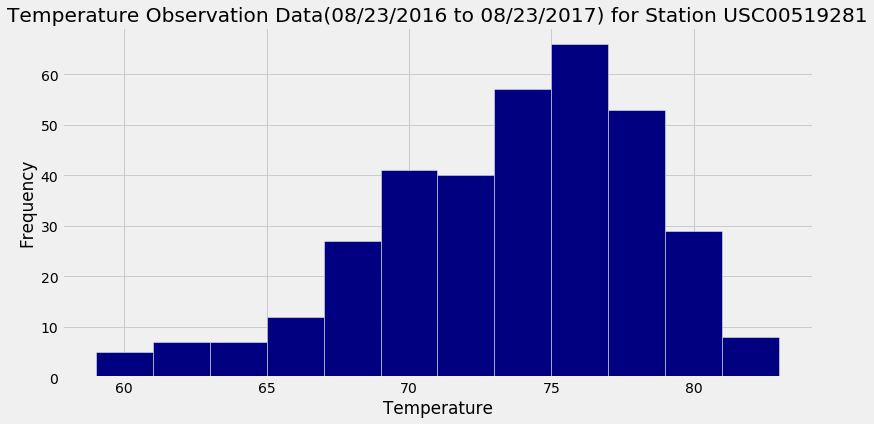

In [27]:
plt.figure(figsize=(12,6))
plt.title("Temperature Observation Data(08/23/2016 to 08/23/2017) for Station USC00519281")
plt.ylabel("Frequency")
sns.histplot(data = temp_df["Temperature"], alpha=1, bins=12, color="navy")
plt.show()

# Close session

In [28]:
session.close()